# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

In [1]:
!nvidia-smi

Sun Mar 20 19:04:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P8     9W / 180W |    632MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours). 

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [5]:
!wandb login {wandb_api_key}

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\onepi/.netrc


In [4]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import wandb
import urllib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'1.11.0+cu113'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [6]:
!dir "dataset"

 Volume in drive D is New Volume
 Volume Serial Number is 221B-65F0

 Directory of D:\Grad_school\Pattern\HW5\dataset

03/03/2022  11:48 PM    <DIR>          .
03/03/2022  11:48 PM    <DIR>          ..
10/10/2018  01:56 AM       167,572,670 features-m10.pk
10/12/2018  01:49 PM       116,539,670 features-m6.pk
10/09/2018  11:54 PM       118,020,170 features-m7.pk
10/09/2018  11:55 PM       109,762,670 features-m8.pk
10/10/2018  12:09 AM       139,258,670 features-m9.pk
10/10/2018  01:39 AM         4,468,763 labels-m10.pk
10/12/2018  01:49 PM         3,107,883 labels-m6.pk
10/09/2018  11:47 PM         3,147,363 labels-m7.pk
10/09/2018  11:47 PM         2,927,163 labels-m8.pk
10/10/2018  12:04 AM         3,713,723 labels-m9.pk
              10 File(s)    668,518,745 bytes
               2 Dir(s)  363,942,813,696 bytes free


In [7]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)
        
        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [8]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features** 
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries 

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [9]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:** 

For each data entry (including timestep), data features are flattened from grid to linear (from 5x5 grid 3 features to 75 linear feature) --> In this point, spatial features and time-relate of each grid are neglected.

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [10]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [11]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [12]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [21]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:**

Because we're going to predict amount of rainfall which is regression task. MSE loss will measures how far is you prediction from ground truth value (Real distance).

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We are using :", device)

We are using : cuda


## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [23]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:**

There is no activation function in the final dense layer. Or we could say "Linear" activation function is used because we want an output to be continuous value, so we won't put any constrain like "ReLU" which strictly output to zero if it negative, or "sigmoid" which squeezing output between 0 and 1.

In [24]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

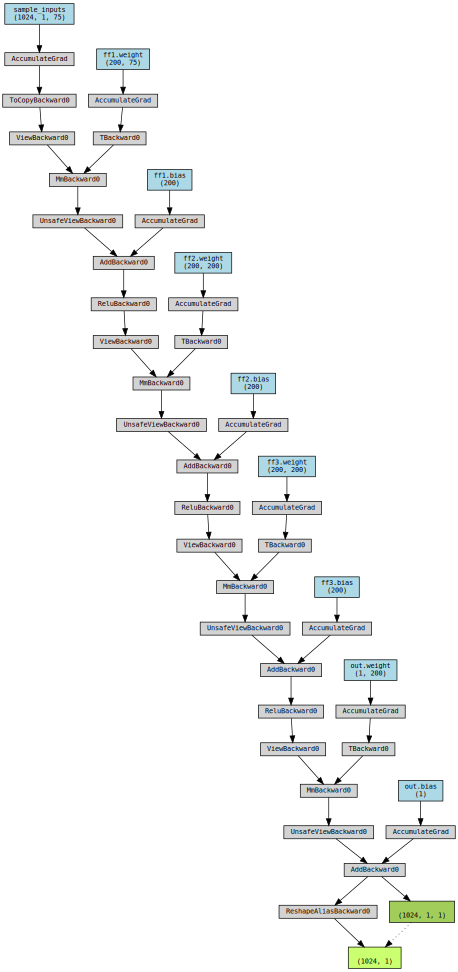

In [17]:
# Visualize model with torchviz
from torchviz import make_dot
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [20]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            --                        --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:**

We set the first hidden layer neuron to 200 which each neuron takes 75 features from input. Additionally, bias term for each neuron which is plus 200. Overall parameters is (200 * 75) + 200 = 15200


# Training

In [21]:
train_losses = []
val_losses = []
learning_rates = []

"""# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)"""

# Log parameters and gradients
"""wandb.watch(model_ff, log='all')"""

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')
    
    """wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })"""

"""wandb.finish()"""
print('Finished Training')

wandb: Currently logged in as: niqulafuse (use `wandb login --relogin` to force relogin)


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9333
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6607
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9236
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6610
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9236
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6603
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9236
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6619
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9236
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6616
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9234
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6622
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9233
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6609
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9236
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6624
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9233
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6611
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9235
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6614



lr,██████▂▂▂▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▂▄▁▆▅▇▃█▄▅
lr,0.0004
train_loss,1.92353
val_loss,1.6614


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

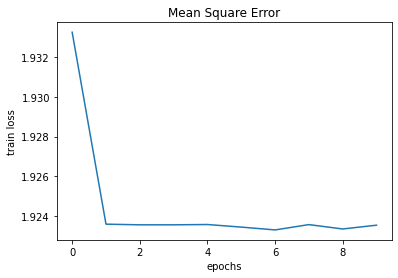

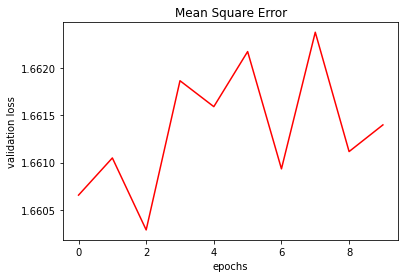

In [23]:
plt.plot(train_losses)
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()
plt.plot(val_losses, c='r')
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.show()

### TODO#6

When does the model start to overfit?

**Ans:**

Around epoch 3-4.

### TODO#7

Plot the learning rate as a function of the epochs.

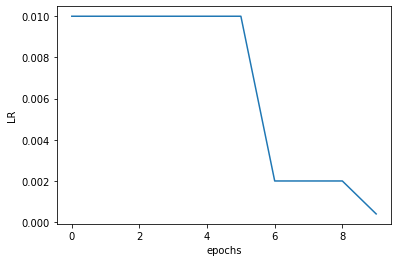

In [24]:
plt.plot(learning_rates)
plt.xlabel("epochs")
plt.ylabel("LR")
plt.show()

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:**

Learning rate is changed when evaluation metric (On validation set, to be percise) has stopped improving for a "patience" number of epochs. in our case 2 epoch.

# Load Model

Use the code snippet below to load the model you just trained

In [25]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 2 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [25]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        
    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']
    
    def check_condition(self, epoch):
        lr_list = [0.0001, 0.0004, 0.0007, 0.001, 0.0008, 0.0007, 0.0005, 0.001, 0.0006, 0.0001, 0.0001]
        lr = lr_list[epoch]
        return lr
    
    def step(self, epoch):
        # Changes the learning rate here
        new_lr = self.check_condition(epoch)
        for params in self.optimizer.param_groups:
            params['lr'] = new_lr
        return new_lr

In [26]:
# Now train with your scheduler
# my_scheduler = MyScheduler(...)
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.0001,
    'hidden_size': 200,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
my_scheduler = MyScheduler(optimizer)

In [27]:
# Train function
def train(model, optimizer, scheduler, train_loader, val_loader, config, scheduler_input="loss", wandb_save=False):
    if wandb_save==True:
        # Start wandb run
        wandb.init(
            project='precipitation-nowcasting',
            config=config,
        )
        # Log parameters and gradients
        wandb.watch(model, log='all')
    
    train_losses = []
    val_losses = []
    learning_rates = []
    for epoch in range(config['epochs']):
        train_loss = []
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        model.train()
        print(f"Training epoch {epoch+1}...")
        print(f"Current LR: {current_lr}")
        
        for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = loss_fn(y_pred, y_true)
            loss.backward()
            optimizer.step()
            train_loss.append(loss)
        
        avg_train_loss = torch.stack(train_loss).mean().item()
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        with torch.no_grad(): # No gradient is required during validation
            print(f"Validating epoch {epoch+1}")
            val_loss = []
            for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
                inputs = inputs.to(device)
                y_true = y_true.to(device)
                y_pred = model(inputs)
                loss = loss_fn(y_pred, y_true)
                val_loss.append(loss)

            avg_val_loss = torch.stack(val_loss).mean().item()
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")
            
            if scheduler != None:
                if scheduler_input == "epoch":
                    scheduler.step(epoch+1)
                elif scheduler_input == "loss":
                    scheduler.step(avg_val_loss)
        
            best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
            if avg_val_loss < best_val_loss:
                state = {
                    'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'best_val_loss': best_val_loss,
                }

                print(f"Saving new best model..")
                torch.save(state, 'model_'+str(model.__class__.__name__)+'.pth.tar')
        if wandb_save==True:
            wandb.log({
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'lr': current_lr,
            })
            
    if wandb_save==True:
        wandb.finish()
    print('Finished Training')
    
    return {"train loss": train_losses, "val loss": val_losses, "lr":learning_rates}

In [47]:
train(model=model_ff, optimizer=optimizer, scheduler=my_scheduler,
      train_loader=train_loader, val_loader=val_loader, config=config, scheduler_input="epoch", wandb_save=False)

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9194
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6575
Saving new best model..
Training epoch 2...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9184
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6581
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9184
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6560
Saving new best model..
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9186
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6567
Training epoch 5...
Current LR: 0.0008


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9182
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6573
Training epoch 6...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9179
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6559
Saving new best model..
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9176
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6560
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9185
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6567
Training epoch 9...
Current LR: 0.0006


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9178
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6564
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9169
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6558
Saving new best model..



lr,▁▃▆█▆▆▄█▅▁
train_loss,█▅▅▆▅▄▃▆▄▁
val_loss,▆█▂▄▆▁▂▄▃▁
lr,0.0001
train_loss,1.91688
val_loss,1.65581


Finished Training


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1 

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:** 

- train loss and val loss show thier loss for each epoch that we can observe our model behavier.
- Gradients part shows gradient distribution for each step. If our model reach the optimum point, gradient trend should be shirnk toward zero, if not we can consider tuning our hyperparameters (if gradient not shrink to zero, we may lower model learning rate)
- Also for Parameters part, we can observe how our model's parameters change over step. This may indicate that the model is learn over time.

# Evaluation

In [83]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")
loaded_model = loaded_model.to(device)

Loaded epoch 9 model


In [28]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    loss = 0
    model.eval()
    with torch.no_grad():
        for idx, (data, y_true) in enumerate(data_loader):
            data = data.to(device)
            y_true = y_true.to(device)
            y_pred = model(data)
            loss += loss_fn(y_pred, y_true)
    mse = loss/len(data_loader)
    return mse

In [22]:
# We will use majority rule as a baseline.
def majority_baseline(train_set, val_set):
    unique, counts = np.unique(train_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    val_set = val_set.reshape(-1,1)
    for r in val_set:
        baseline += (majority - r) ** 2 / len(val_set)
    return baseline

In [23]:
print('baseline')
print('train', majority_baseline(y_train, y_train))
print('validate', majority_baseline(y_train, y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [86]:
print('FF-model')
print('train', evaluate(train_loader, loaded_model).item())
print('validate', evaluate(val_loader, loaded_model).item())

FF-model
train 1.9169749021530151
validate 1.6558082103729248


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [85]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardDropout(nn.Module):
    def __init__(self, input_size=75, output_size=1, hidden_size=200, dropout_rate=0.2):
        super(FeedForwardDropout, self).__init__()
        self.ff1 = nn.Linear(input_size, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.ff1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.ff2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.ff3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
    
        return x.reshape(-1, 1)

In [115]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config_dropout = {
    'architecture': 'feedforward_dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff_dropout = FeedForwardDropout(hidden_size=config_dropout['hidden_size'], dropout_rate=0.2)
model_ff_dropout = model_ff_dropout.to(device)
optimizer = torch.optim.Adam(model_ff_dropout.parameters(), lr=config_dropout['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config_dropout['scheduler_factor'], 
    patience=config_dropout['scheduler_patience'], 
    min_lr=config_dropout['scheduler_min_lr']
)

history = train(model=model_ff_dropout, optimizer=optimizer, scheduler=scheduler,
                train_loader=train_loader, val_loader=val_loader, config=config_dropout, scheduler_input="loss", wandb_save=True)

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9352
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6617
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9234
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6633
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9235
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6614
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9234
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6615
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9234
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6619
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9238
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6612
Saving new best model..
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9236
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6606
Saving new best model..
Training epoch 8...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9236
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6612
Training epoch 9...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9237
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6611
Training epoch 10...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9236
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6612



lr,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▃▄▃▁▃▂▂
lr,0.01
train_loss,1.9236
val_loss,1.66115


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

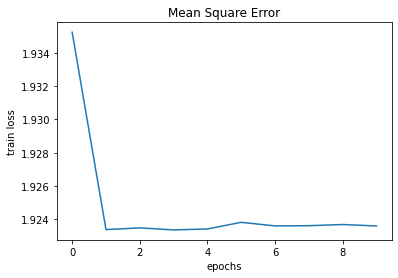

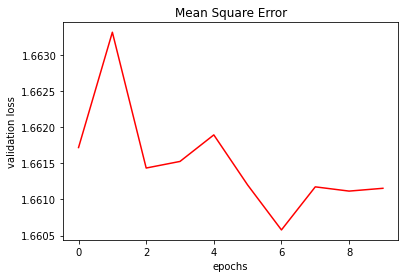

In [116]:
# Plot here
plt.plot(history['train loss'])
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()
plt.plot(history['val loss'], c='r')
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.show()

In [149]:
def get_model(model, path, config):
    checkpoint = torch.load(path)
    loaded_model = model(hidden_size=config['hidden_size']) # Create model object
    loaded_model.load_state_dict(checkpoint['model']) # Load weights
    print(f"Loaded epoch {checkpoint['epoch']} model")
    loaded_model = loaded_model.to(device)
    return loaded_model

In [98]:
# Evaluate
print('FF-Dropout-model')
loaded_model = get_model(model=FeedForwardDropout, path='model_FeedForwardDropout.pth.tar', config=config_dropout)
print('train', evaluate(train_loader, loaded_model).item())
print('validate', evaluate(val_loader, loaded_model).item())

FF-Dropout-model
Loaded epoch 6 model
train 1.9237030744552612
validate 1.660577416419983


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [73]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def CNN_preprocessing(data, label):
    x = data.reshape((-1, 5, 5, 3))
    y = label.reshape((-1, 1))
    return x, y

class normalizer_std_cnn():
    def __init__(self):
        self.scalers = {}
    
    def fit(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3))
        for i in range(X.shape[2]):
            self.scalers[i] = preprocessing.StandardScaler()
            self.scalers[i].fit(X[:,:,i])
        return self
    
    def transform(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3)) 
        for i in range(X.shape[2]):
            X[:,:,i] = self.scalers[i].transform(X[:,:,i]) 
        return X.reshape((-1, 5, 5, 3))
    
class CNNDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.x = np.moveaxis(self.x, -1, 1)
        self.y = y.astype(np.float32)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [181]:
# Data preprocessing
x_train_cnn, y_train_cnn = CNN_preprocessing(x_train, y_train)
x_val_cnn, y_val_cnn = CNN_preprocessing(x_val, y_val)
x_test_cnn, y_test_cnn = CNN_preprocessing(x_test, y_test)

# Normalization for CNN
CNN_norm = normalizer_std_cnn()
CNN_norm.fit(data=x_train_cnn)

x_train_cnn = CNN_norm.transform(data=x_train_cnn)
x_val_cnn = CNN_norm.transform(data=x_val_cnn)
x_test_cnn = CNN_norm.transform(data=x_test_cnn)

# Create dataset
train_dataset_cnn = CNNDataset(x_train_cnn, y_train_cnn)
val_dataset_cnn = CNNDataset(x_val_cnn, y_val_cnn)
test_dataset_cnn = CNNDataset(x_test_cnn, y_test_cnn)

# Data loader
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)

In [209]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class Conv2DNN(nn.Module):
    def __init__(self, input_channel=3, output_size=1, hidden_size=200):
        super(Conv2DNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=input_channel, out_channels=hidden_size,
                              kernel_size=3, stride=1, padding='valid')
        self.fc1 = nn.Linear(3*3*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv(x).flatten(start_dim=1))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x

In [213]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config_cnn = {
    'architecture': 'CNN',
    'lr': 0.0005,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 20
}

# Model
torch.manual_seed(121)
model_cnn = Conv2DNN(hidden_size=config_cnn['hidden_size'])
model_cnn = model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=config_cnn['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config_cnn['scheduler_factor'], 
    patience=config_cnn['scheduler_patience'], 
    min_lr=config_cnn['scheduler_min_lr']
)

history = train(model=model_cnn, optimizer=optimizer, scheduler=scheduler,
                train_loader=train_loader_cnn, val_loader=val_loader_cnn, config=config_cnn, scheduler_input="loss", wandb_save=False)

start training conv2d
Training epoch 1...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9210
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6567
Saving new best model..
Training epoch 2...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9185
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6565
Saving new best model..
Training epoch 3...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9181
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6565
Saving new best model..
Training epoch 4...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9181
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6558
Saving new best model..
Training epoch 5...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9180
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6564
Training epoch 6...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9183
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6562
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9179
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6558
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9182
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6562
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9179
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6560
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9180
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6558
Training epoch 11...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 11 train loss: 1.9179
Validating epoch 11


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 11 val loss: 1.6562
Training epoch 12...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 12 train loss: 1.9177
Validating epoch 12


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 12 val loss: 1.6562
Training epoch 13...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 13 train loss: 1.9179
Validating epoch 13


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 13 val loss: 1.6564
Training epoch 14...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 14 train loss: 1.9179
Validating epoch 14


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 14 val loss: 1.6560
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 15 train loss: 1.9181
Validating epoch 15


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 15 val loss: 1.6562
Training epoch 16...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 16 train loss: 1.9177
Validating epoch 16


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 16 val loss: 1.6561
Training epoch 17...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 17 train loss: 1.9179
Validating epoch 17


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 17 val loss: 1.6560
Training epoch 18...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 18 train loss: 1.9179
Validating epoch 18


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 18 val loss: 1.6562
Training epoch 19...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 19 train loss: 1.9179
Validating epoch 19


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 19 val loss: 1.6562
Training epoch 20...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 20 train loss: 1.9176
Validating epoch 20


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 20 val loss: 1.6562
Finished Training


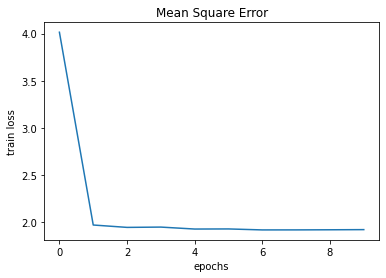

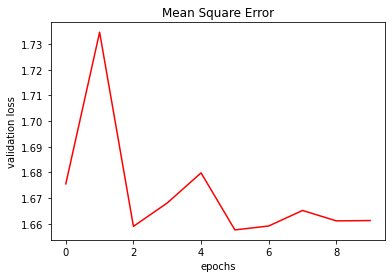

In [164]:
# Plot here
plt.plot(history['train loss'])
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()
plt.plot(history['val loss'], c='r')
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.show()

In [215]:
# Evaluate
print('CNN-model')
loaded_model = get_model(model=Conv2DNN, path='model_Conv2DNN.pth.tar', config=config_cnn)
print('train', evaluate(train_loader_cnn, loaded_model).item())
print('validate', evaluate(val_loader_cnn, loaded_model).item())

CNN-model
Loaded epoch 3 model
train 1.9184238910675049
validate 1.655809760093689


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [104]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def GRU_preprocessing(data, label):
    x = data.reshape((-1, 5, 75))
    y = label.reshape((-1, 5))
    return x, y

class normalizer_std_gru():
    def __init__(self):
        self.scalers = preprocessing.StandardScaler()
    
    def fit(self, data):
        X = data.copy()
        X = X.reshape((-1, 75))
        self.scalers.fit(X)
        return self
    
    def transform(self, data):
        X = data.copy()
        X = X.reshape((-1, 75))
        X = self.scalers.transform(X) 
        return X.reshape(-1, 5, 75)
    
class GRUDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [113]:
# Data preprocessing
x_train_gru, y_train_gru = GRU_preprocessing(x_train, y_train)
x_val_gru, y_val_gru = GRU_preprocessing(x_val, y_val)
x_test_gru, y_test_gru = GRU_preprocessing(x_test, y_test)

# Normalization for GRU
GRU_norm = normalizer_std_gru()
GRU_norm.fit(data=x_train_gru)

x_train_gru = GRU_norm.transform(data=x_train_gru)
x_val_gru = GRU_norm.transform(data=x_val_gru)
x_test_gru = GRU_norm.transform(data=x_test_gru)

# Create dataset
train_dataset_gru = GRUDataset(x_train_gru, y_train_gru)
val_dataset_gru = GRUDataset(x_val_gru, y_val_gru)
test_dataset_gru = GRUDataset(x_test_gru, y_test_gru)

# Data loader
train_loader_gru = DataLoader(train_dataset_gru, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_gru = DataLoader(val_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_gru = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)

In [114]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class GRUModel(nn.Module):
    def __init__(self, input_size=75, output_size=1, hidden_size=200):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x, h = self.gru(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.out(x)
        return np.squeeze(x)

In [116]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
loss_fn = nn.MSELoss()
config_gru = {
    'architecture': 'GRU',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_gru = GRUModel(hidden_size=config_gru['hidden_size'])
model_gru = model_gru.to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=config_gru['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config_gru['scheduler_factor'], 
    patience=config_gru['scheduler_patience'], 
    min_lr=config_gru['scheduler_min_lr']
)

history = train(model=model_gru, optimizer=optimizer, scheduler=scheduler,
                train_loader=train_loader_gru, val_loader=val_loader_gru,
                config=config_gru, scheduler_input="loss", wandb_save=False)

start training gru
Training epoch 1...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9251
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6751
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9149
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6710
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9095
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6688
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9090
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6687
Saving new best model..
Training epoch 5...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9087
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6699
Training epoch 6...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9098
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6751
Training epoch 7...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9132
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6724
Training epoch 8...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9113
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6691
Training epoch 9...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9146
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6693
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9029
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6686
Saving new best model..
Finished Training


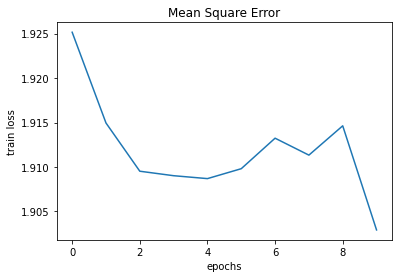

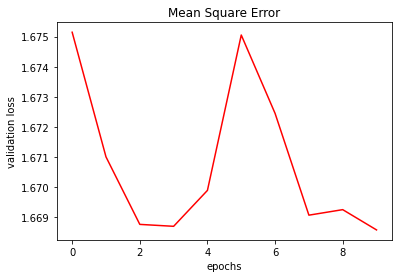

In [117]:
# Plot
plt.plot(history['train loss'])
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()
plt.plot(history['val loss'], c='r')
plt.title("Mean Square Error")
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.show()

In [118]:
# Evaluate
print('GRU-model')
loaded_model = get_model(model=GRUModel, path='model_GRUModel.pth.tar', config=config_gru)
print('train', evaluate(train_loader_gru, loaded_model).item())
print('validate', evaluate(val_loader_gru, loaded_model).item())

GRU-model
Loaded epoch 9 model
train 1.9158204793930054
validate 1.6685786247253418


# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [72]:
# Prep data as you see fit
def hybrid_preprocessing(data, label):
    x = data.reshape((-1, 5, 5, 3))
    y = label.reshape((-1, 5))
    return x, y

class normalizer_std_hybrid():
    def __init__(self):
        self.scalers = {}
    
    def fit(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3))
        for i in range(X.shape[2]):
            self.scalers[i] = preprocessing.StandardScaler()
            self.scalers[i].fit(X[:,:,i])
        return self
    
    def transform(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3)) 
        for i in range(X.shape[2]):
            X[:,:,i] = self.scalers[i].transform(X[:,:,i]) 
        return X.reshape((-1, 5, 5, 5, 3))
    
class hybridDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.x = np.moveaxis(self.x, -1, 2)
        self.y = y.astype(np.float32)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [110]:
# Data preprocessing
x_train_hyb, y_train_hyb = hybrid_preprocessing(x_train, y_train)
x_val_hyb, y_val_hyb = hybrid_preprocessing(x_val, y_val)
x_test_hyb, y_test_hyb = hybrid_preprocessing(x_test, y_test)

# Normalization for CNN
hybrid_norm = normalizer_std_hybrid()
hybrid_norm.fit(data=x_train_hyb)

x_train_hyb = hybrid_norm.transform(data=x_train_hyb)
x_val_hyb = hybrid_norm.transform(data=x_val_hyb)
x_test_hyb = hybrid_norm.transform(data=x_test_hyb)

# Create dataset
train_dataset_hyb = hybridDataset(x_train_hyb, y_train_hyb)
val_dataset_hyb = hybridDataset(x_val_hyb, y_val_hyb)
test_dataset_hyb = hybridDataset(x_test_hyb, y_test_hyb)

# Data loader
train_loader_hyb = DataLoader(train_dataset_hyb, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_hyb = DataLoader(val_dataset_hyb, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_hyb = DataLoader(test_dataset_hyb, batch_size=1024, shuffle=False, pin_memory=True)

In [146]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class CNNGRUNet(nn.Module):
    def __init__(self, input_channel=3, output_size=1, hidden_channel=10, hidden_size=128):
        super(CNNGRUNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=hidden_channel, kernel_size=2)
        self.batchnorm_conv1 = nn.BatchNorm2d(hidden_channel)
        self.conv2 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel*2, kernel_size=2)
        self.batchnorm_conv2 = nn.BatchNorm2d(hidden_channel*2)
        self.maxpool = nn.MaxPool2d(kernel_size=3) 
        self.gru = nn.GRU(hidden_channel*2, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.layernorm_gru = nn.LayerNorm(hidden_size)
        #self.fcMatch = nn.Linear(9, 75)
        self.fc1 = nn.Linear(hidden_size, hidden_size*2)
        self.layernorm_fc1 = nn.LayerNorm(hidden_size*2)
        #self.fc2 = nn.Linear(hidden_size*2, hidden_size*4)
        #self.fc3 = nn.Linear(hidden_size*4, hidden_size*2)
        self.out = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # CNN Section
        x_gru = torch.zeros((x.shape[0], x.shape[1], 20)).to(device)
        for i in range(5):
            x_cnn = x[:, i, :, :, :]
            x_cnn = self.conv1(x_cnn)
            x_cnn = self.relu(x_cnn)
            x_cnn = self.batchnorm_conv1(x_cnn)
            x_cnn = self.conv2(x_cnn)
            x_cnn = self.relu(x_cnn)
            x_cnn = self.batchnorm_conv2(x_cnn)
            x_cnn = self.maxpool(x_cnn)
            x_cnn = x_cnn.flatten(start_dim=1) #2*2*200.
            #x_cnn = self.fcMatch(x_cnn)
            x_gru[:, i, :] = x_cnn
        
        x, h = self.gru(x_gru)
        x = self.relu(x)
        x = self.layernorm_gru(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.layernorm_fc1(x)
        x = self.dropout(x)
        """x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.relu(x)"""
        x = self.out(x)
        
        return np.squeeze(x)
    
class SiameseNet(nn.Module):
    def __init__(self, input_channel=3, output_size=1, hidden_channel=32, hidden_size=128):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=hidden_channel, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel*2, kernel_size=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3) 
        self.gru = nn.GRU(75, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        #self.fcMatch = nn.Linear(9, 75)
        self.fc1 = nn.Linear((hidden_channel*2 + hidden_size), hidden_size*4)
        #self.fc2 = nn.Linear(hidden_size*2, hidden_size*4)
        #self.fc3 = nn.Linear(hidden_size*4, hidden_size*2)
        self.out = nn.Linear(hidden_size*4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # CNN Section
        x_c = torch.zeros((x.shape[0], x.shape[1], 64)).to(device)
        for i in range(5):
            x_cnn = x[:, i, :, :, :]
            x_cnn = self.conv1(x_cnn)
            x_cnn = self.relu(x_cnn)
            x_cnn = self.conv2(x_cnn)
            x_cnn = self.relu(x_cnn)
            x_cnn = self.maxpool(x_cnn)
            x_cnn = x_cnn.flatten(start_dim=1) #1*1*20.
            #x_cnn = self.fcMatch(x_cnn)
            x_c[:, i, :] = x_cnn
        
        x_gru = x.reshape((-1, 5, 75))
        x_gru, h = self.gru(x_gru)
        x_gru = self.relu(x_gru)
        x = torch.concat((x_c, x_gru), axis=2)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        """x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.relu(x)"""
        x = self.out(x)
        
        return np.squeeze(x)

In [112]:
model_hb = CNNGRUNet().to(device)

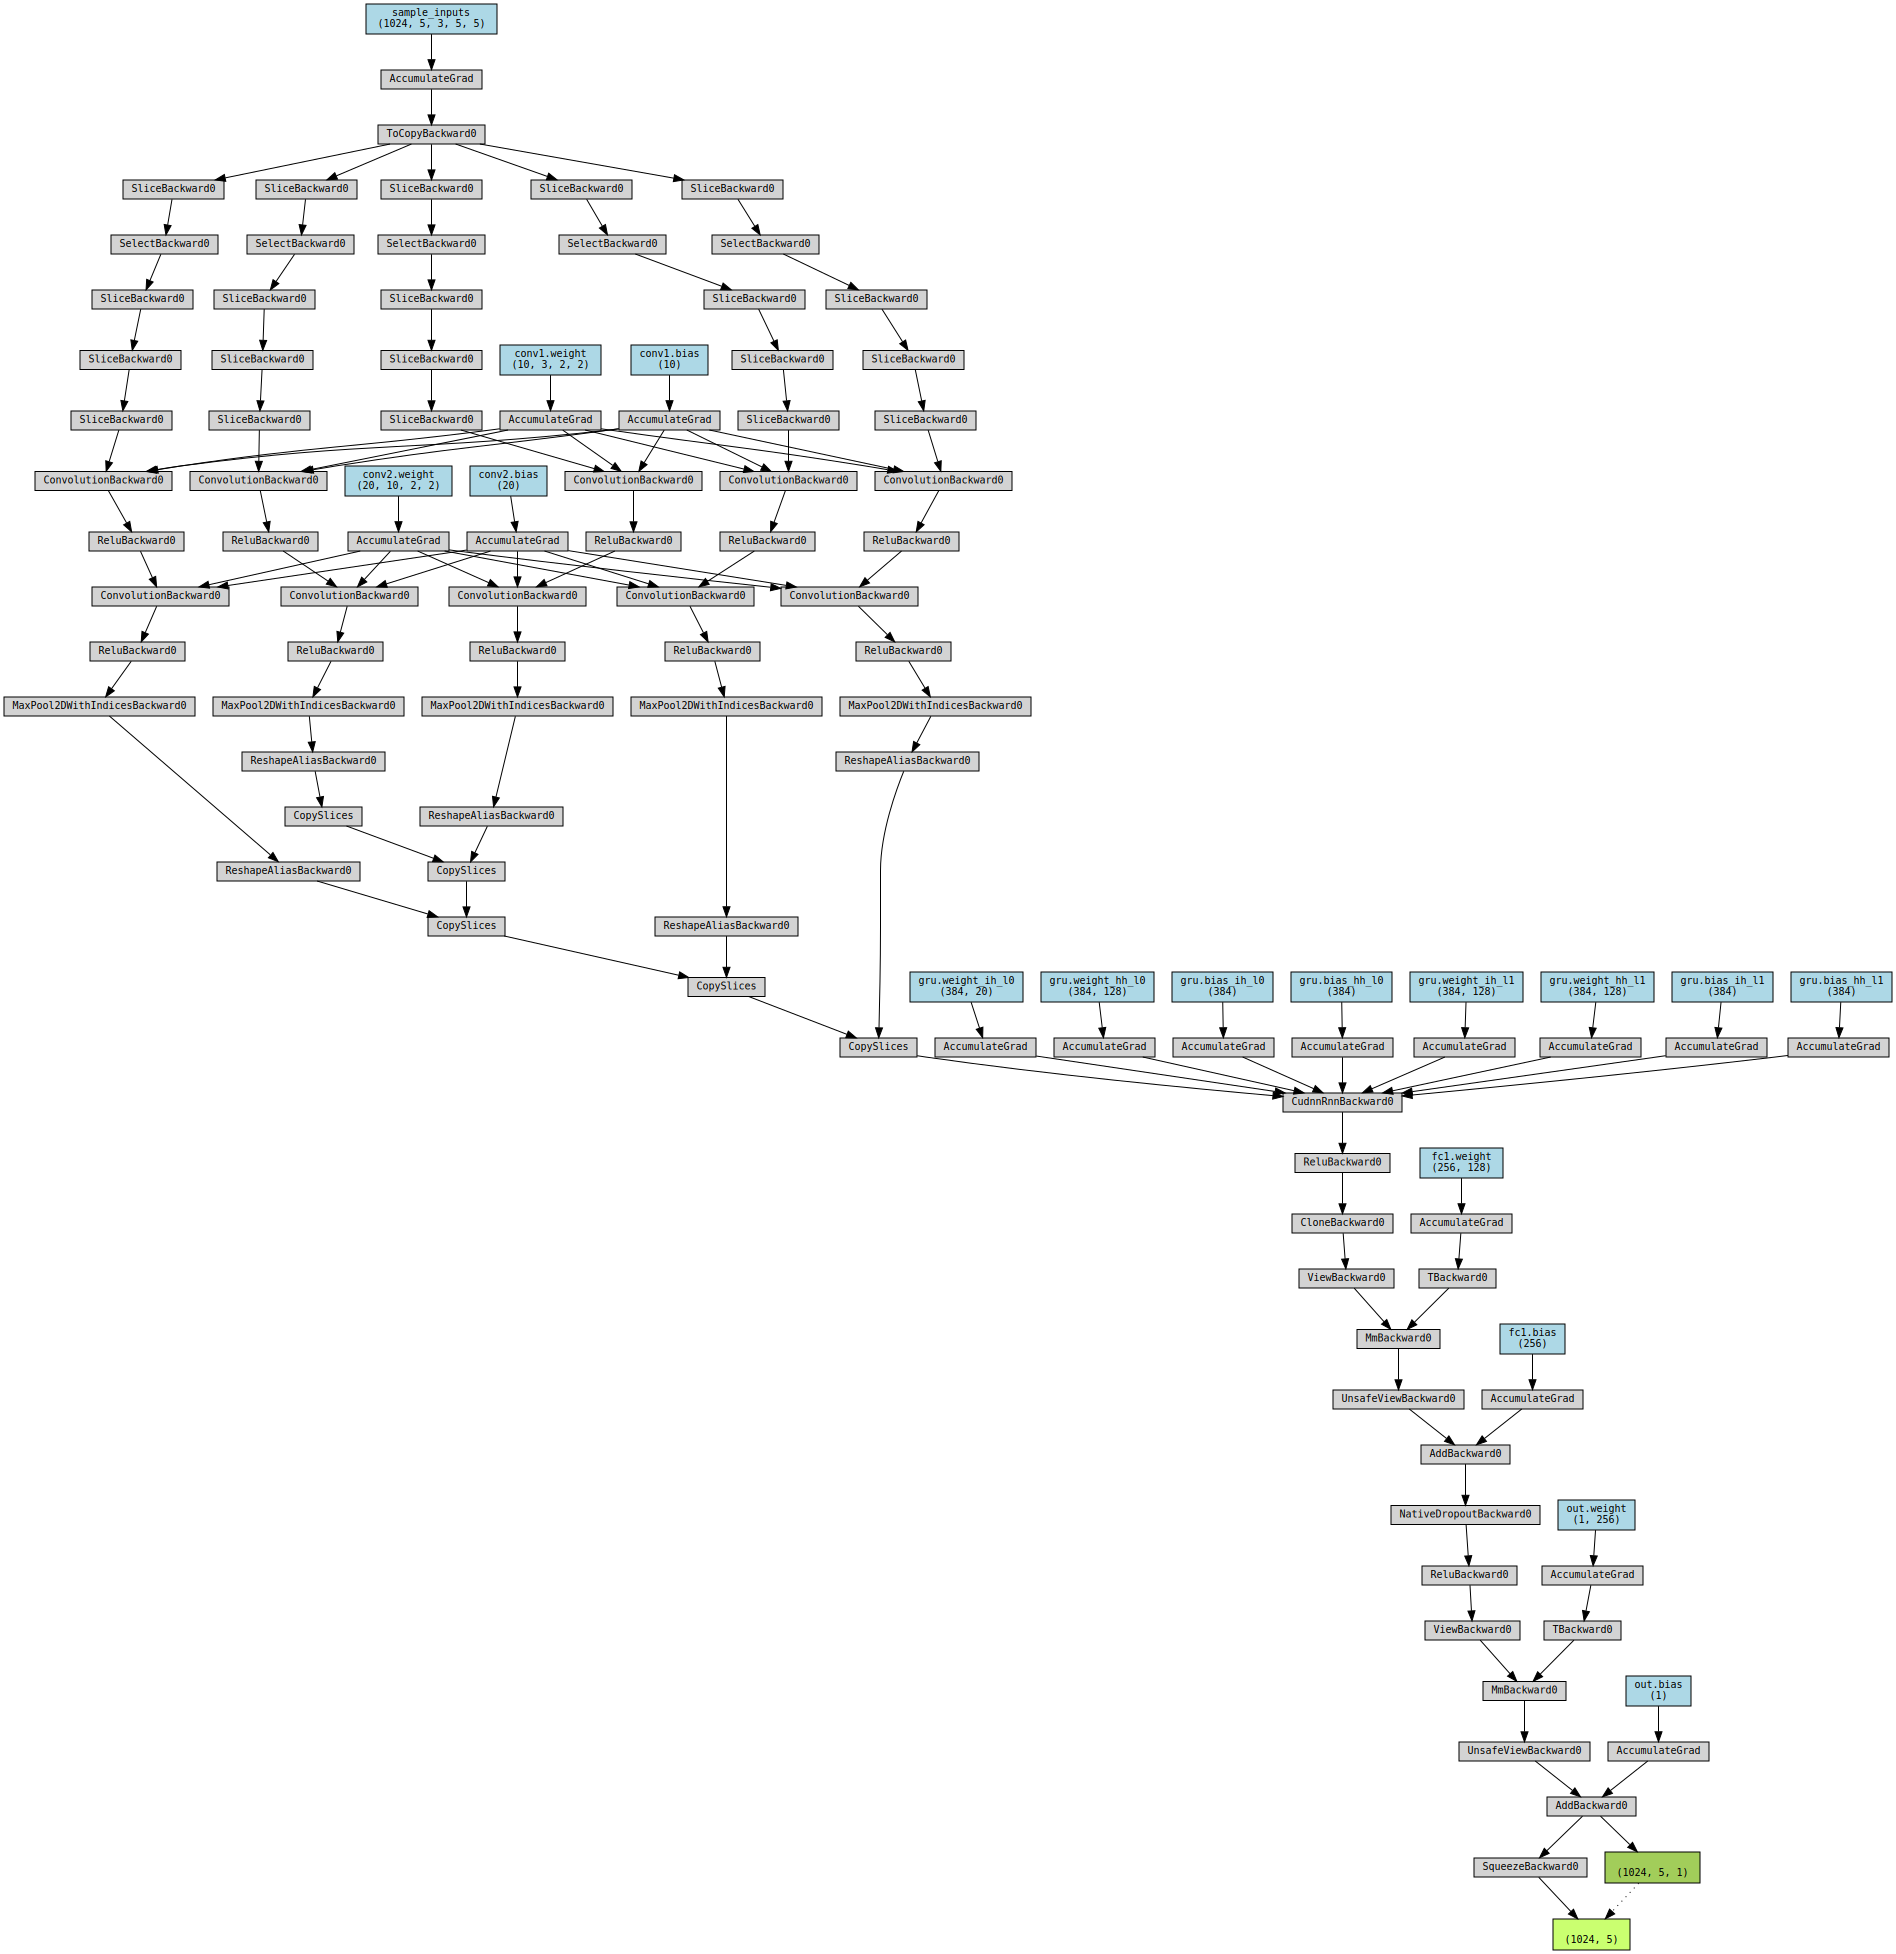

In [115]:
# Visualize model with torchviz
from torchviz import make_dot
sample_inputs = next(iter(train_loader_hyb))[0].requires_grad_(True)
sample_y = model_hb(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_hb.named_parameters())+[('sample_inputs', sample_inputs)]))

In [140]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
loss_fn = nn.MSELoss()
config_hb = {
    'architecture': 'HybridCNN-GRU',
    'lr': 0.0005,
    'hidden_size': 128,
    'scheduler_factor': 0.9,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_hb = CNNGRUNet(hidden_size=config_hb['hidden_size'])
model_hb = model_hb.to(device)
optimizer = torch.optim.Adam(model_hb.parameters(), lr=config_hb['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config_hb['scheduler_factor'], 
    patience=config_hb['scheduler_patience'], 
    min_lr=config_hb['scheduler_min_lr']
)

history = train(model=model_hb, optimizer=optimizer, scheduler=scheduler,
                train_loader=train_loader_hyb, val_loader=val_loader_hyb,
                config=config_hb, scheduler_input="loss", wandb_save=False)

start training the best model
Training epoch 1...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9174
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6714
Saving new best model..
Training epoch 2...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9265
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6697
Saving new best model..
Training epoch 3...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9152
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6681
Saving new best model..
Training epoch 4...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9129
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6718
Training epoch 5...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9167
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6680
Saving new best model..
Training epoch 6...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9085
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6680
Training epoch 7...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9098
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6679
Saving new best model..
Training epoch 8...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9082
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6688
Training epoch 9...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9086
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6706
Training epoch 10...
Current LR: 0.00040500000000000003


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9058
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6679
Saving new best model..
Finished Training


In [160]:
# Evaluate best model on validation and test set
print('CNNGRU-model # Convolute first, then pass conv output to recurrent unit')
loaded_model = get_model(model=CNNGRUNet, path='model_CNNGRUNet.pth.tar', config=config_hb)
print('validate', evaluate(val_loader_hyb, loaded_model).item())
print('test', evaluate(test_loader_hyb, loaded_model).item())

print('\nSiamese-model # Pass input to Conv, GRU in parallel scheme then concatenate and pass to FC layer')
loaded_model = get_model(model=SiameseNet, path='model_SiameseNet.pth.tar', config=config_hb)
print('validate', evaluate(val_loader_hyb, loaded_model).item())
print('test', evaluate(test_loader_hyb, loaded_model).item())

CNNGRU-model # Convolute first, then pass conv output to recurrent unit
Loaded epoch 9 model
validate 1.667851209640503
test 1.1507552862167358

Siamese-model # Pass input to Conv, GRU in parallel scheme then concatenate and pass to FC layer
Loaded epoch 4 model
validate 1.667472243309021
test 1.152024269104004


In [143]:
# Also evaluate your fully-connected model and CNN/GRU model on the test set.
print('FF-Dropout-model')
loaded_model = get_model(model=FeedForwardDropout, path='model_FeedForwardDropout.pth.tar', config=config_dropout)
print('validate', evaluate(val_loader, loaded_model).item())
print('test', evaluate(test_loader, loaded_model).item())

print('\nCNN-model')
loaded_model = get_model(model=Conv2DNN, path='model_Conv2DNN.pth.tar', config=config_cnn)
print('validate', evaluate(val_loader_cnn, loaded_model).item())
print('test', evaluate(test_loader_cnn, loaded_model).item())

print('\nGRU-model')
loaded_model = get_model(model=GRUModel, path='model_GRUModel.pth.tar', config=config_gru)
print('validate', evaluate(val_loader_gru, loaded_model).item())
print('test', evaluate(test_loader_gru, loaded_model).item())

FF-Dropout-model
Loaded epoch 6 model
validate 1.660577416419983
test 1.164641261100769

CNN-model
Loaded epoch 9 model
validate 1.6567449569702148
test 1.1621754169464111

GRU-model
Loaded epoch 9 model
validate 1.6685786247253418
test 1.1525726318359375


To get full credit for this part, your best model should be better than the previous models on the **test set**. 

### TODO#22

Explain what helped and what did not help here

**Ans:**

By combining CNN and GRU in image-time-related dataset. This approach combine inductive bias from Convolution and Recurrent which helps model generalize more and achieve the best result in final evaluation. Effect of other hyperparamters are shown as follow:

***Effective***: Dropout, Complex arch, Decrease LR

***Ineffective***: Increase iteration, Increase hidden size, Change activation



# [Optional] Augmentation using data loader

### Optional TODO#2

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [34]:
# Adding noise
def Gaussian_noise(mean, var, size):
    std = np.sqrt(var)
    noise = np.random.normal(loc=mean, scale=std, size=size)
    return noise

In [126]:
def Augmented_preprocessing(data, label):
    x = data.reshape((-1, 5, 5, 5, 3))
    y = label.reshape((-1, 5))
    return x, y

class normalizer_std_Augmented():
    def __init__(self):
        self.scalers = {}
    
    def fit(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3))
        for i in range(X.shape[2]):
            self.scalers[i] = preprocessing.StandardScaler()
            self.scalers[i].fit(X[:,:,i])
        return self
    
    def transform(self, data):
        X = data.copy()
        X = X.reshape((-1, 25, 3)) 
        for i in range(X.shape[2]):
            X[:,:,i] = self.scalers[i].transform(X[:,:,i]) 
        return X.reshape((5, 5, 5, 3))

In [131]:
# Write Dataset/DataLoader with noise here
class AugmentedDataset(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.normalizer = normalizer
        self.y = y.astype(np.float32)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        p = np.random.uniform(0,1,1)
        if p >= 0.5:
            noise = Gaussian_noise(0, 0.1, x.shape)
            x += noise
        x = self.normalizer.transform(x)
        
        x = np.moveaxis(x, -1, 1)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [134]:
# Data preprocessing
x_train_aug, y_train_aug = Augmented_preprocessing(x_train, y_train)
x_val_aug, y_val_aug = Augmented_preprocessing(x_val, y_val)
x_test_aug, y_test_aug = Augmented_preprocessing(x_test, y_test)

# Normalization for CNN
Augmented_norm = normalizer_std_Augmented().fit(data=x_train_aug)

# Create dataset
train_dataset_aug = AugmentedDataset(x_train_aug, y_train_aug, Augmented_norm)
val_dataset_aug = AugmentedDataset(x_val_aug, y_val_aug, Augmented_norm)
test_dataset_aug = AugmentedDataset(x_test_aug, y_test_aug, Augmented_norm)

# Data loader
train_loader_aug = DataLoader(train_dataset_aug, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=1024, shuffle=False, pin_memory=True)

In [151]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
loss_fn = nn.MSELoss()
config_aug = {
    'architecture': 'HybridCNN-GRU',
    'lr': 0.0005,
    'hidden_size': 128,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_hb = CNNGRUNet(hidden_size=config_hb['hidden_size'])
model_hb = model_hb.to(device)
optimizer = torch.optim.Adam(model_hb.parameters(), lr=config_hb['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config_hb['scheduler_factor'], 
    patience=config_hb['scheduler_patience'], 
    min_lr=config_hb['scheduler_min_lr']
)

history = train(model=model_hb, optimizer=optimizer, scheduler=scheduler,
                train_loader=train_loader_aug, val_loader=val_loader_aug,
                config=config_aug, scheduler_input="loss", wandb_save=False)

start training the best model with noise
Training epoch 1...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9594
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6731
Saving new best model..
Training epoch 2...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9143
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6694
Saving new best model..
Training epoch 3...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9115
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6710
Training epoch 4...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9157
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6776
Training epoch 5...
Current LR: 0.0005


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9136
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6696
Training epoch 6...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9143
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6687
Saving new best model..
Training epoch 7...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9086
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6681
Saving new best model..
Training epoch 8...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9077
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6683
Training epoch 9...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9077
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6681
Saving new best model..
Training epoch 10...
Current LR: 0.00045000000000000004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9120
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6681
Finished Training


In [152]:
# Evaluate the best model trained with noise on validation and test set
print('CNNGRU-model # Convolute first, then pass conv output to recurrent unit')
loaded_model = get_model(model=CNNGRUNet, path='model_CNNGRUNet.pth.tar', config=config_aug)
print('validate', evaluate(val_loader_aug, loaded_model).item())
print('test', evaluate(test_loader_aug, loaded_model).item())

CNNGRU-model # Convolute first, then pass conv output to recurrent unit
Loaded epoch 8 model
validate 1.6680841445922852
test 1.1541861295700073
